In [1]:
pip install numpy pandas xgboost scikit-learn scikit-optimize gym stable-baselines3 torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Load data
df = pd.read_csv('eda_simulation_data.csv')
df.head(10)

,Wirelength,RoutingLayers,PlacementDensity,TimingSlack,PowerConsumption
0,13.528105,4,0.962412,0.647190,67.056209
1,10.800314,7,0.821140,2.419969,91.600629
2,11.957476,7,0.758182,2.304252,93.914952
3,14.481786,5,0.783620,1.051821,78.963573
4,13.735116,9,0.768228,3.126488,117.470232
5,8.045444,5,0.568385,1.695456,66.090888
6,11.900177,9,0.835784,3.309982,113.800354
7,9.697286,8,0.589359,3.030271,99.394571
8,9.793562,5,0.919088,1.520644,69.587125
9,10.821197,7,0.531453,2.417880,91.642394


In [3]:
# Display basic information about the dataset
print(df.info())

# Get descriptive statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Wirelength        1000 non-null   float64
 1   RoutingLayers     1000 non-null   int64  
 2   PlacementDensity  1000 non-null   float64
 3   TimingSlack       1000 non-null   float64
 4   PowerConsumption  1000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 39.2 KB
None
        Wirelength  RoutingLayers  PlacementDensity  TimingSlack  \
count  1000.000000     1000.00000       1000.000000  1000.000000   
mean      9.909487        6.57600          0.753696     2.297051   
std       1.975054        1.68614          0.144680     0.865923   
min       3.907714        4.00000          0.500093     0.595791   
25%       8.603160        5.00000          0.627686     1.547120   
50%       9.883944        7.00000          0.753243     2.336945   
75%      11.213901        8.00000 

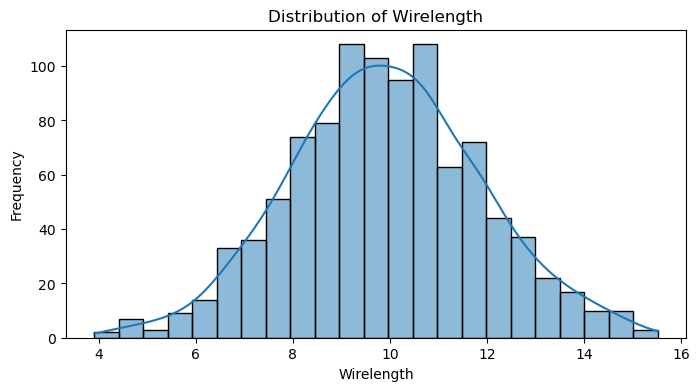

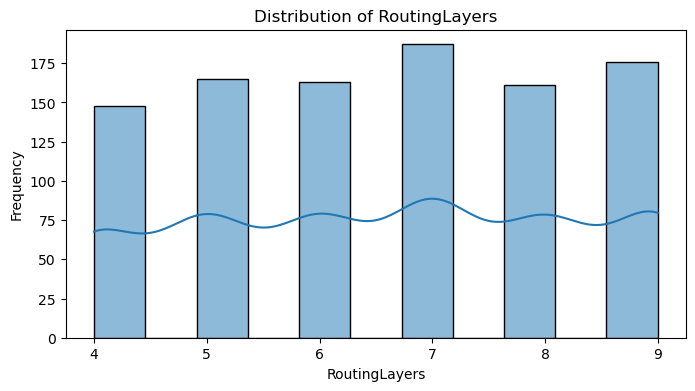

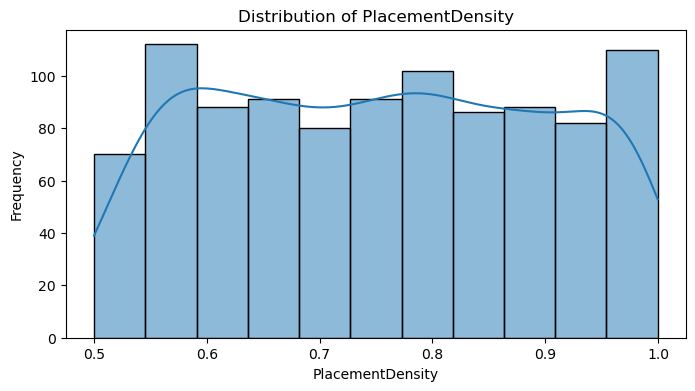

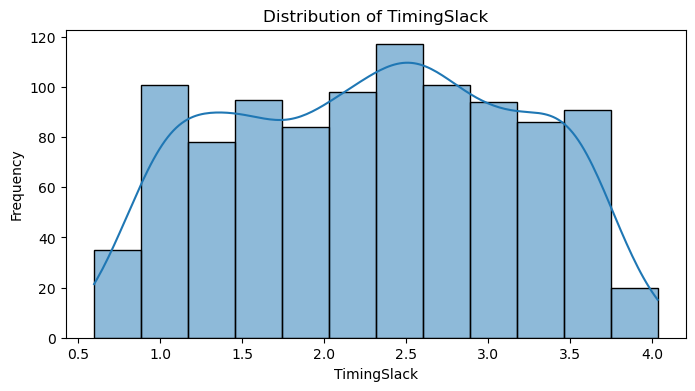

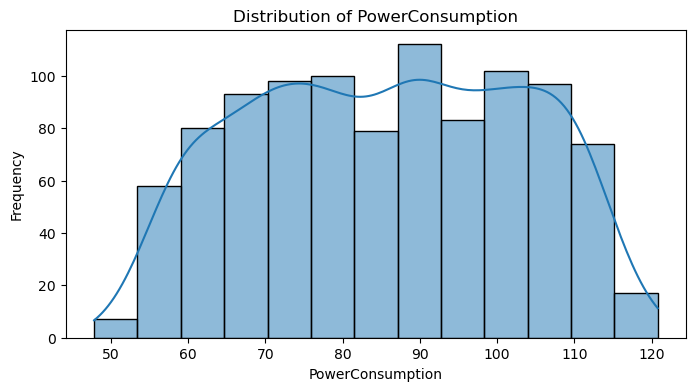

In [4]:
# Plot distributions of all numerical features
for column in df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


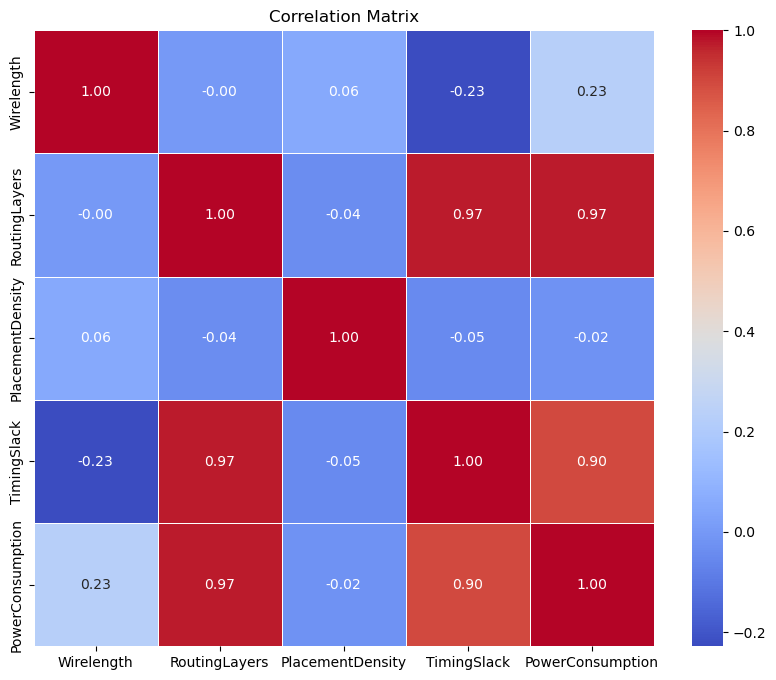

In [5]:
# Correlation matrix
correlation = df.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

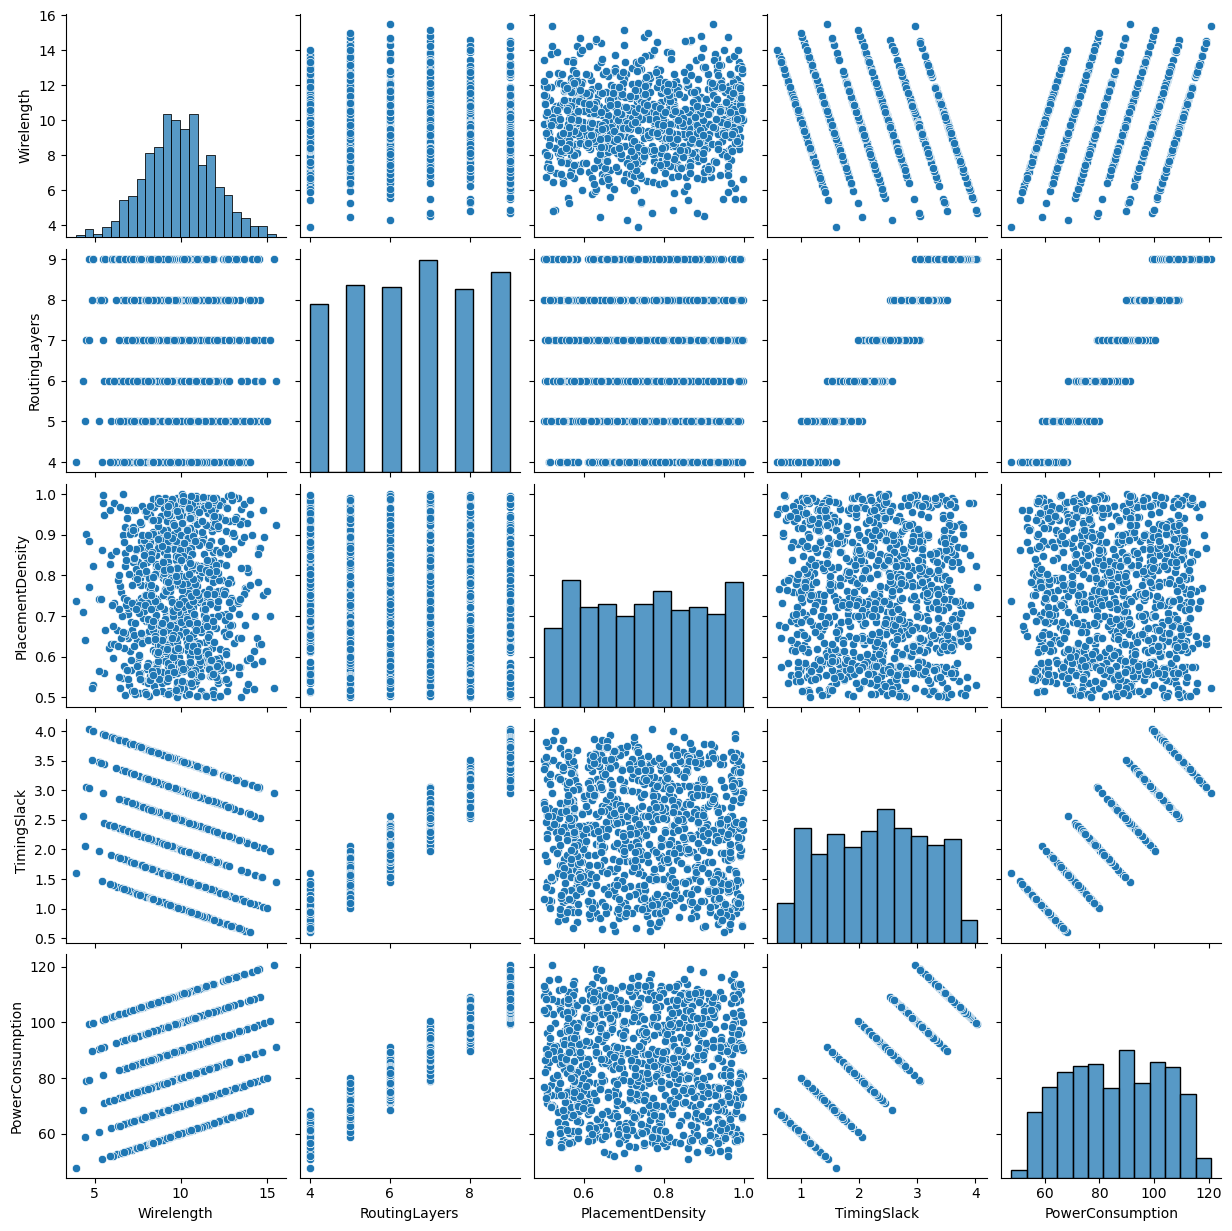

In [6]:
# Pairplot to visualize the relationships between features
sns.pairplot(df)
plt.show()

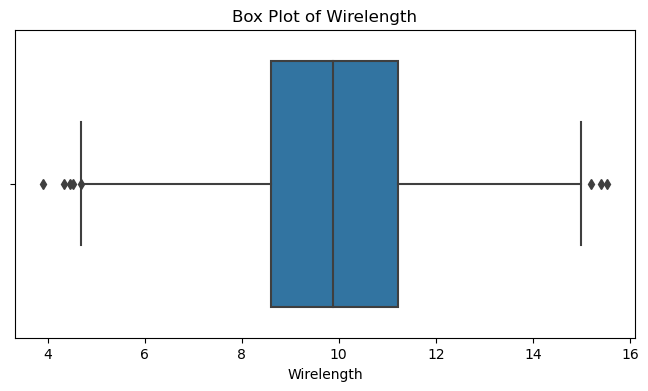

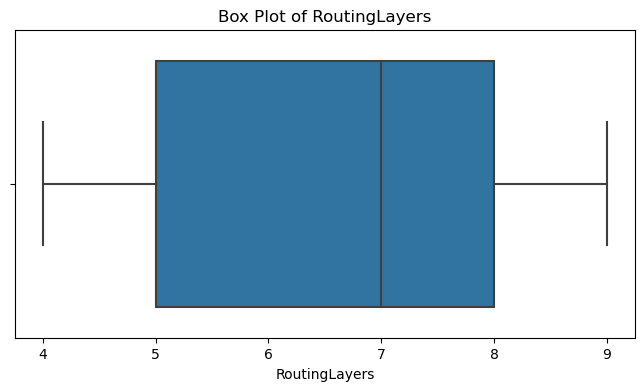

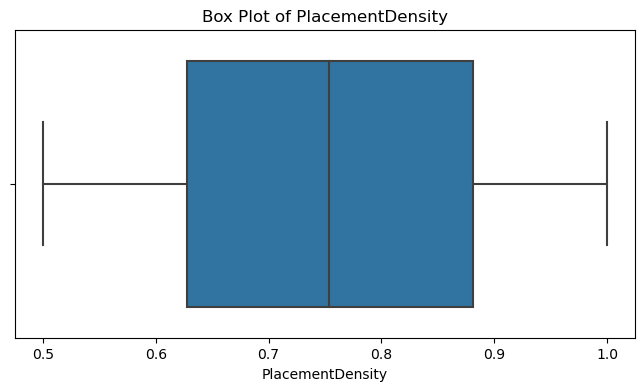

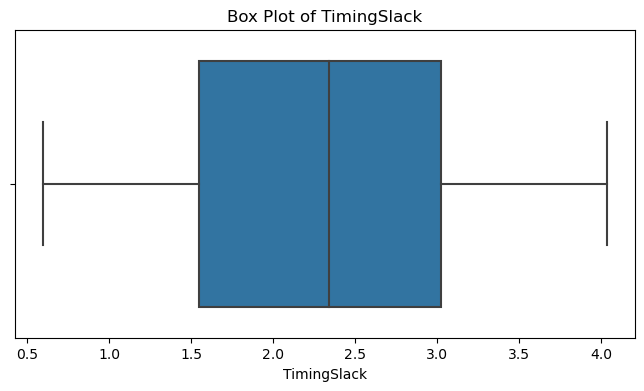

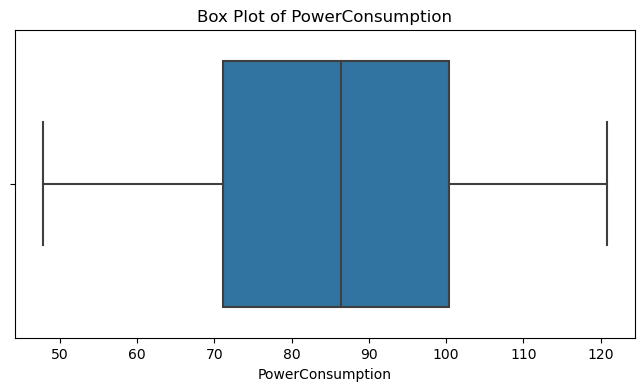

In [7]:
# Box plots for each feature
for column in df.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

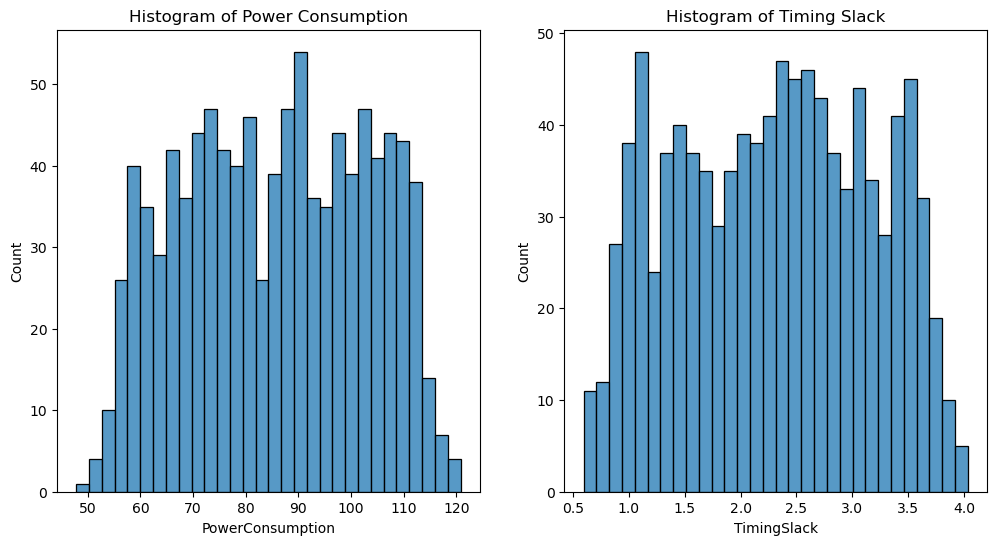

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['PowerConsumption'], bins=30, kde=False)
plt.title('Histogram of Power Consumption')

plt.subplot(1, 2, 2)
sns.histplot(df['TimingSlack'], bins=30, kde=False)
plt.title('Histogram of Timing Slack')
plt.show()

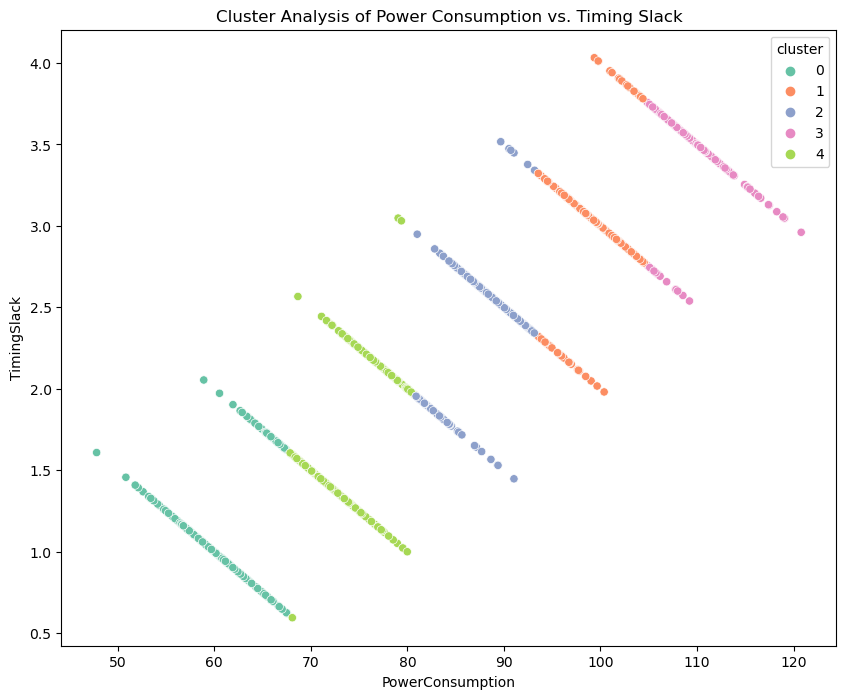

                  Wirelength  RoutingLayers  PlacementDensity  TimingSlack  \
Wirelength          1.000000      -0.000142          0.056236    -0.228225   
RoutingLayers      -0.000142       1.000000         -0.038093     0.973641   
PlacementDensity    0.056236      -0.038093          1.000000    -0.049915   
TimingSlack        -0.228225       0.973641         -0.049915     1.000000   
PowerConsumption    0.227963       0.973637         -0.024263     0.895946   
cluster             0.089105       0.229512         -0.028773     0.203131   

                  PowerConsumption   cluster  
Wirelength                0.227963  0.089105  
RoutingLayers             0.973637  0.229512  
PlacementDensity         -0.024263 -0.028773  
TimingSlack               0.895946  0.203131  
PowerConsumption          1.000000  0.243794  
cluster                   0.243794  1.000000  
Cluster 0, Coefficient: 0.009607010440831485, Intercept: 0.5970739459901755
Cluster 1, Coefficient: 0.04193669831853462, Int

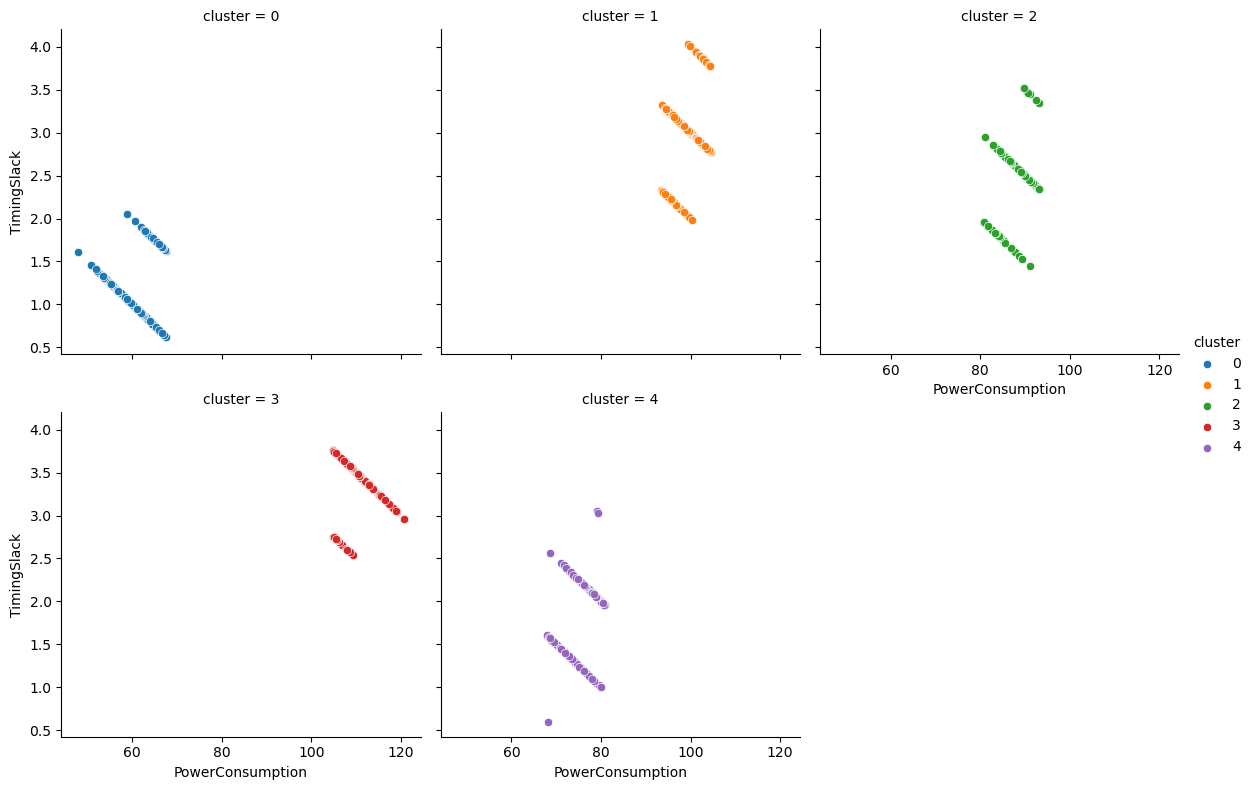

In [13]:
from sklearn.cluster import KMeans

# Assume an arbitrary number of clusters to start
kmeans = KMeans(n_clusters=5)
df['cluster'] = kmeans.fit_predict(df[['PowerConsumption', 'TimingSlack']])

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='PowerConsumption', y='TimingSlack', hue='cluster', palette='Set2')
plt.title('Cluster Analysis of Power Consumption vs. Timing Slack')
plt.show()

import numpy as np

# Correlation matrix
print(df.corr())

# Linear regression analysis within each cluster
from sklearn.linear_model import LinearRegression

for i in np.unique(df['cluster']):
    subset = df[df['cluster'] == i]
    reg = LinearRegression().fit(subset[['PowerConsumption']], subset['TimingSlack'])
    print(f'Cluster {i}, Coefficient: {reg.coef_[0]}, Intercept: {reg.intercept_}')


g = sns.FacetGrid(df, col="cluster", hue="cluster", col_wrap=3, height=4)
g.map(sns.scatterplot, "PowerConsumption", "TimingSlack")
g.add_legend()
plt.show()

In [15]:
# Split data into features and target
X = df.drop(columns=['TimingSlack', 'PowerConsumption'])
y = df['TimingSlack']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=50, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
# Predict and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Bayesian Optimization for minimizing power consumption
space = [
    Real(0.1, 2.0, name='scaling_factor'),
    Integer(4, 10, name='routing_layers')
]

@use_named_args(space)
def objective(**params):
    # Update model params
    model.set_params(**params)
    # Fake power calculation: assume power is inversely related to scaling factor and directly to routing layers
    fake_power = 1000 / params['scaling_factor'] + 50 * params['routing_layers']
    return fake_power

# Run Bayesian Optimization
result = gp_minimize(objective, space, n_calls=30)
print("Best parameters for minimal power consumption:")
print(result.x)

Mean Squared Error: 0.0003156490237124557


/Users/rohitreddymandla/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 4] before, using random point [1.9645397389837862, 8]
  warnings.warn(
/Users/rohitreddymandla/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 4] before, using random point [1.9784683020199332, 6]
  warnings.warn(
/Users/rohitreddymandla/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 4] before, using random point [0.6642353144897832, 7]
  warnings.warn(
/Users/rohitreddymandla/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 4] before, using random point [0.41155321442804715, 5]
  warnings.warn(


Best parameters for minimal power consumption:
[2.0, 4]


In [27]:
import gym
from gym import spaces
import numpy as np

class SimpleEDAEnv(gym.Env):
    """A simple EDA placement environment."""
    metadata = {'render.modes': ['console']}

    def __init__(self):
        super(SimpleEDAEnv, self).__init__()
        
        # Define action and observation space
        # They must be gym.spaces objects
        # Example: 5x5 grid, actions: move up, down, left, right for a single component
        self.grid_size = 5
        self.component_pos = [2, 2]  # Start at the center of the grid
        self.target_pos = [4, 4]  # Target position to minimize wirelength
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(low=0, high=5, shape=(2,), dtype=np.int32)

    def reset(self):
        # Reset the state of the environment to an initial state
        self.component_pos = [2, 2]  # Reset component to center
        return np.array(self.component_pos)

    def step(self, action):
        # Execute one time step within the environment
        if action == 0 and self.component_pos[0] > 0:
            self.component_pos[0] -= 1  # Move up
        if action == 1 and self.component_pos[0] < self.grid_size - 1:
            self.component_pos[0] += 1  # Move down
        if action == 2 and self.component_pos[1] > 0:
            self.component_pos[1] -= 1  # Move left
        if action == 3 and self.component_pos[1] < self.grid_size - 1:
            self.component_pos[1] += 1  # Move right

        # Calculate reward
        wirelength = -np.sum(np.abs(np.array(self.target_pos) - np.array(self.component_pos)))
        done = np.array_equal(self.component_pos, self.target_pos)

        return np.array(self.component_pos), wirelength, done, {}

    def render(self, mode='console'):
        if mode != 'console':
            raise NotImplementedError("Only console mode is supported.")
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.component_pos[0], self.component_pos[1]] = 1
        grid[self.target_pos[0], self.target_pos[1]] = 2
        print(grid)

    def close(self):
        pass


In [11]:
pip install 'shimmy>=2.0'

Note: you may need to restart the kernel to use updated packages.


In [28]:
from stable_baselines3 import DQN

def train_model():
    # Create the environment
    env = SimpleEDAEnv()

    # Instantiate the agent
    model = DQN("MlpPolicy", env, verbose=1)
    
    # Train the agent
    model.learn(total_timesteps=10000)

    # Save the agent
    model.save("dqn_eda_optimization")
    print("Model trained and saved!")

    # Test the trained agent
    obs = env.reset()
    for _ in range(20):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = env.step(action)
        env.render()
        if dones:
            print("Component placed optimally.")
            break

train_model()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2831     |
|    time_elapsed     | 0        |
|    total_timesteps  | 153      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.76     |
|    n_updates        | 13       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1687     |
|    time_elapsed     | 0        |
|    total_timesteps  | 305      |
| train/              |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.3     |
|    ep_rew_mean      | -153     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 68       |
|    fps              | 1303     |
|    time_elapsed     | 4        |
|    total_timesteps  | 5935     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.163    |
|    n_updates        | 1458     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.1     |
|    ep_rew_mean      | -156     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 72       |
|    fps              | 1316     |
|    time_elapsed     | 5        |
|    total_timesteps  | 6706     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00572  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 56.1     |
|    ep_rew_mean      | -70.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 1311     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8096     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0515   |
|    n_updates        | 1998     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 49.9     |
|    ep_rew_mean      | -61.1    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 136      |
|    fps              | 1310     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8112     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0969   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.35     |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 1299     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8370     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000597 |
|    n_updates        | 2067     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.35     |
|    ep_rew_mean      | -6.94    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 1299     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8386     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | -6.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 1291     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8636     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.103    |
|    n_updates        | 2133     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | -6.49    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 1291     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8652     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.228    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | -6.43    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 324      |
|    fps              | 1282     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8900     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.366    |
|    n_updates        | 2199     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | -6.34    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 1282     |
|    time_elapsed     | 6        |
|    total_timesteps  | 8916     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0914   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | -6.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 388      |
|    fps              | 1273     |
|    time_elapsed     | 7        |
|    total_timesteps  | 9170     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 2267     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | -6.52    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 1273     |
|    time_elapsed     | 7        |
|    total_timesteps  | 9186     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | -6.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 1266     |
|    time_elapsed     | 7        |
|    total_timesteps  | 9441     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0465   |
|    n_updates        | 2335     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | -6.63    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 1266     |
|    time_elapsed     | 7        |
|    total_timesteps  | 9457     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.29     |
|    ep_rew_mean      | -6.73    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 1261     |
|    time_elapsed     | 7        |
|    total_timesteps  | 9717     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.355    |
|    n_updates        | 2404     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.31     |
|    ep_rew_mean      | -6.78    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 520      |
|    fps              | 1261     |
|    time_elapsed     | 7        |
|    total_timesteps  | 9735     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.27     |
|    ep_rew_mean      | -6.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 1252     |
|    time_elapsed     | 7        |
|    total_timesteps  | 9988     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.244    |
|    n_updates        | 2471     |
----------------------------------
Model trained and saved!
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2.]]
Component placed optimally.


In [29]:
from stable_baselines3 import DQN
import numpy as np

def evaluate_model(model_path, num_episodes=100):
    # Load the trained model
    model = DQN.load(model_path)

    # Create the environment
    env = SimpleEDAEnv()

    rewards = []
    success_count = 0
    steps_per_episode = []

    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        total_rewards = 0
        steps = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_rewards += reward
            steps += 1

        # Collect statistics
        rewards.append(total_rewards)
        steps_per_episode.append(steps)
        if reward == 0:  # Assuming reaching the target gives the highest reward of 0 (no wirelength)
            success_count += 1

    # Calculate statistics
    average_reward = np.mean(rewards)
    success_rate = success_count / num_episodes
    average_steps = np.mean(steps_per_episode)

    print(f"Average Reward: {average_reward:.2f}")
    print(f"Success Rate: {success_rate:.2%}")
    print(f"Average Steps per Episode: {average_steps:.2f}")

# Assuming the model is saved as "dqn_eda_optimization.zip"
evaluate_model("dqn_eda_optimization.zip")


Average Reward: -6.00
Success Rate: 100.00%
Average Steps per Episode: 4.00
